Currently we're using a certain [hdf5 file](https://hrrrzarr.s3.amazonaws.com/index.html#grid/) to get indices from latitude and longitude to select HRRR Zarr data by chunk. Here I load that file, make enhancements, save it, and demonstrate use of the enhanced file.

## New file format creation

In [1]:
import numpy as np
import xarray as xr

def add_chunk_index_data(x_or_y, length):
    chunk_size = 150
    
    main_index = np.arange(length)
    ds[f"index_{x_or_y}"] = ((x_or_y), main_index)
    
    chunk_index = main_index // chunk_size
    ds[f"chunk_{x_or_y}"] = ((x_or_y), chunk_index)
    
    index_in_chunk = main_index % chunk_size
    ds[f"in_chunk_{x_or_y}"] = ((x_or_y), index_in_chunk)
    

grid_map = '../scratch/HRRR_latlon.h5'
ds = xr.open_dataset(grid_map, engine="netcdf4")
y_length, x_length = ds.latitude.shape
add_chunk_index_data("x", x_length)
add_chunk_index_data("y", y_length)
ds = ds.rename(phony_dim_1="x", phony_dim_0="y")

ds

<xarray.Dataset>
Dimensions:     (x: 1799, y: 1059)
Dimensions without coordinates: x, y
Data variables:
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    index_x     (x) int64 0 1 2 3 4 5 6 7 ... 1792 1793 1794 1795 1796 1797 1798
    chunk_x     (x) int64 0 0 0 0 0 0 0 0 0 0 ... 11 11 11 11 11 11 11 11 11 11
    in_chunk_x  (x) int64 0 1 2 3 4 5 6 7 8 ... 141 142 143 144 145 146 147 148
    index_y     (y) int64 0 1 2 3 4 5 6 7 ... 1052 1053 1054 1055 1056 1057 1058
    chunk_y     (y) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 6 6 6 7 7 7 7 7 7 7 7 7
    in_chunk_y  (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 148 149 0 1 2 3 4 5 6 7 8

In [2]:
print(ds.chunk_x)
print(ds.chunk_y)

<xarray.DataArray 'chunk_x' (x: 1799)>
array([ 0,  0,  0, ..., 11, 11, 11])
Dimensions without coordinates: x
<xarray.DataArray 'chunk_y' (y: 1059)>
array([0, 0, 0, ..., 7, 7, 7])
Dimensions without coordinates: y


In [20]:
chunk_x_vector = ds.chunk_x.to_masked_array().reshape(1799, 1)
chunk_y_vector = ds.chunk_y.to_masked_array().reshape(1, 1059)

format_chunk_ids = np.vectorize(lambda y, x: '{}.{}'.format(int(y), int(x)))
chunk_ids = format_chunk_ids(chunk_y_vector, chunk_x_vector)
ds["chunk_id"] = (("x", "y"), chunk_ids)

In [21]:
ds

<xarray.Dataset>
Dimensions:     (x: 1799, y: 1059)
Dimensions without coordinates: x, y
Data variables:
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    index_x     (x) int64 0 1 2 3 4 5 6 7 ... 1792 1793 1794 1795 1796 1797 1798
    chunk_x     (x) int64 0 0 0 0 0 0 0 0 0 0 ... 11 11 11 11 11 11 11 11 11 11
    in_chunk_x  (x) int64 0 1 2 3 4 5 6 7 8 ... 141 142 143 144 145 146 147 148
    index_y     (y) int64 0 1 2 3 4 5 6 7 ... 1052 1053 1054 1055 1056 1057 1058
    chunk_y     (y) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 6 6 6 7 7 7 7 7 7 7 7 7
    in_chunk_y  (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 148 149 0 1 2 3 4 5 6 7 8
    chunk_id    (x, y) <U4 '0.0' '0.0' '0.0' '0.0' ... '7.11' '7.11' '7.11'

The new data structure has all the indices we need to find the nearest gridpoint by latitude and longitude, find which chunk it's in, and find it based on the indices within the chunk.

But it's still very hard to look up by nearest latitude and longitude, since these depend on more than one dimension. Looking up by projection x and y makes a lot more sense, so we add those back in.

In [22]:
import cartopy.crs as ccrs

projection = ccrs.LambertConformal(central_longitude=-97.5,
                             central_latitude=38.5,
                             standard_parallels=[38.5])
transform = np.vectorize(lambda i, j: projection.transform_point(i, j, ccrs.PlateCarree()))

grid_y = ds.isel(x=0)
grid_x = ds.isel(y=0)

_, proj_y = transform(grid_y.longitude, grid_y.latitude)
proj_x, _ = transform(grid_x.longitude, grid_x.latitude)

ds["x"] = proj_x
ds["y"] = proj_y

ds

<xarray.Dataset>
Dimensions:     (x: 1799, y: 1059)
Coordinates:
  * x           (x) float64 -2.701e+06 -2.698e+06 ... 2.697e+06 2.7e+06
  * y           (y) float64 -1.581e+06 -1.578e+06 ... 1.584e+06 1.587e+06
Data variables:
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    index_x     (x) int64 0 1 2 3 4 5 6 7 ... 1792 1793 1794 1795 1796 1797 1798
    chunk_x     (x) int64 0 0 0 0 0 0 0 0 0 0 ... 11 11 11 11 11 11 11 11 11 11
    in_chunk_x  (x) int64 0 1 2 3 4 5 6 7 8 ... 141 142 143 144 145 146 147 148
    index_y     (y) int64 0 1 2 3 4 5 6 7 ... 1052 1053 1054 1055 1056 1057 1058
    chunk_y     (y) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 6 6 6 7 7 7 7 7 7 7 7 7
    in_chunk_y  (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 148 149 0 1 2 3 4 5 6 7 8
    chunk_id    (x, y) <U4 '0.0' '0.0' '0.0' '0.0' ... '7.11' '7.11' '7.11'

In [24]:
ds.to_netcdf("HRRR_chunk_index.h5", engine="scipy")

## Using the new file

Now let's demonstrate using this enhanced file to get some example data closest to SLC.

In [25]:
ds = xr.open_dataset("HRRR_chunk_index.h5", engine="scipy")
ds

<xarray.Dataset>
Dimensions:     (x: 1799, y: 1059)
Coordinates:
  * x           (x) float64 -2.701e+06 -2.698e+06 ... 2.697e+06 2.7e+06
  * y           (y) float64 -1.581e+06 -1.578e+06 ... 1.584e+06 1.587e+06
Data variables:
    chunk_id    (x, y) object ...
    index_x     (x) int32 ...
    chunk_x     (x) int32 ...
    in_chunk_x  (x) int32 ...
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    index_y     (y) int32 ...
    chunk_y     (y) int32 ...
    in_chunk_y  (y) int32 ...

First, we need to get the nearest point:

In [27]:
import cartopy.crs as ccrs

projection = ccrs.LambertConformal(central_longitude=-97.5,
                             central_latitude=38.5,
                             standard_parallels=[38.5])

x, y = projection.transform_point(-111.8910, 40.7608, ccrs.PlateCarree())

nearest_point = ds.sel(x=x, y=y, method="nearest")

print(nearest_point)

<xarray.Dataset>
Dimensions:     ()
Coordinates:
    x           float64 -1.211e+06
    y           float64 3.46e+05
Data variables:
    chunk_id    object ...
    index_x     int32 496
    chunk_x     int32 3
    in_chunk_x  int32 46
    latitude    float64 ...
    longitude   float64 ...
    index_y     int32 644
    chunk_y     int32 4
    in_chunk_y  int32 44


Next, we need to get the chunk url to download from S3:

In [29]:
chunk_id = nearest_point.chunk_id.values
print(chunk_id)

4.3


In [30]:
root_path = "sfc/20210108/20210108_00z_fcst.zarr/surface/TMP/surface/TMP/0."
url = root_path + chunk_id

import boto3
from botocore import UNSIGNED
from botocore.config import Config

s3 = boto3.resource(service_name='s3', region_name='us-west-1', config=Config(signature_version=UNSIGNED))
obj = s3.Object('hrrrzarr', url)
obj = obj.get()['Body'].read()

We do have to manually decompress this, there's probably no way getting around that given that we're only reading part of the zarr array so APIs don't handle everything nicely for us.

In [31]:
import numcodecs as ncd

# Surface-level pressure requires dtype="<f4", the default should be correct for everything else
def decompress_fcst_chunk(data, dtype="<f2"):
    buffer = ncd.blosc.decompress(data)
    chunk = np.frombuffer(buffer, dtype=dtype)
    entry_size = 22500
    data_array = np.reshape(chunk, (len(chunk)//entry_size, 150, 150))
    return data_array

chunk_data = decompress_fcst_chunk(obj)

Now that we have the data as a simple numpy array, we can use the in-chunk indices to access the data at our point:

In [32]:
slc_forecast = chunk_data[:, nearest_point.in_chunk_x.values, nearest_point.in_chunk_y.values]
slc_forecast

array([273.8, 272.2, 271.2, 268.2, 268. , 268.2, 268.2, 268.2, 268.2,
       268.2, 268.5, 267.8, 266.8, 266. , 265.5, 267.8, 273.8, 278.5,
       281.8, 283.5, 284.2, 283.5, 281.2, 277.8, 273.8, 272. , 272.8,
       272.8, 272.8, 271. , 269.2, 268.2, 269. , 269. , 270.2, 270.2,
       271.2, 271.8, 272.2, 272.5, 273.2, 273.5, 275.5, 277.2, 277.5,
       277.2, 276.5, 273.8], dtype=float16)

Let's visualize this:

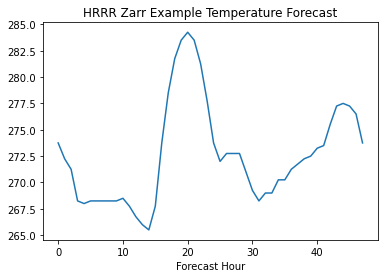

In [33]:
import matplotlib.pyplot as plt

plt.title("HRRR Zarr Example Temperature Forecast")
plt.xlabel("Forecast Hour")
plt.plot(slc_forecast)

## Getting a Region

Let's look up data from a box around the Four Corners region.

In [72]:
lat_top = 39
lat_bottom = 34
lon_top = -107
lon_bottom = -110

def check_boundaries(data):
    return (lat_bottom < data.latitude) & (data.latitude < lat_top) & (lon_bottom < data.longitude) & (data.longitude < lon_top)

We can open the enhanced lat/lon file as before, but this time we'll filter using the latitude and longitude fields, so we don't have to mess with the projection coordinates. (Note that if you're looking for a single gridpoint and know the exact latitude/longitude, you could also use look up by lat/lon, but if you want to look for the nearest gridpoint, you do need to change into the projection coordinates for xarray to find it for you.)

In [35]:
ds = xr.open_dataset("HRRR_chunk_index.h5", engine="scipy")
area = ds.where(check_boundaries, drop=True)
area

<xarray.Dataset>
Dimensions:     (x: 110, y: 194)
Coordinates:
  * x           (x) float64 -1.151e+06 -1.148e+06 ... -8.268e+05 -8.238e+05
  * y           (y) float64 -4.504e+05 -4.474e+05 ... 1.243e+05 1.273e+05
Data variables:
    chunk_id    (x, y) object nan nan nan nan nan nan ... nan nan nan nan nan
    index_x     (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    chunk_x     (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    in_chunk_x  (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    latitude    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    longitude   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    index_y     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    chunk_y     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    in_chunk_y  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

Note that while we've dropped rows and columns with *no* datapoints in the box, we still have lots of null datapoints where either the projection x or the projection y coordinate is sometimes within the box, but the combination is not.

Let's get the unique chunk ids from this dataset.

In [63]:
chunk_ids = area.chunk_id.fillna(None).values.flatten()
chunk_ids = chunk_ids[chunk_ids != None]
chunk_ids = np.unique(chunk_ids)
chunk_ids

array(['2.3', '2.4', '3.3', '3.4'], dtype=object)

Now we download the chunks from AWS, decompress, and join the chunk data with the grid data.

In [79]:
%%time
def get_chunk_data(chunk_id):
    root_path = "sfc/20210108/20210108_00z_anl.zarr/surface/TMP/surface/TMP/"
    url = root_path + chunk_id
    obj = s3.Object('hrrrzarr', url)
    obj = obj.get()['Body'].read()
    array = decompress_analysis_chunk(obj)
    return array
    
def decompress_analysis_chunk(data, dtype="<f2"):
    buffer = ncd.blosc.decompress(data)
    chunk = np.frombuffer(buffer, dtype=dtype)
    data_array = np.reshape(chunk, (150, 150))
    return data_array

def get_chunk_with_grid(chunk_id):
    chunk_xarray = ds.where(lambda x: x.chunk_id == chunk_id, drop=True)
    chunk_xarray["TMP"] = (("y", "x"), get_chunk_data(chunk_id))
    return chunk_xarray

chunks = [get_chunk_with_grid(chunk_id) for chunk_id in chunk_ids]
data = xr.merge(chunks)
print(data)

<xarray.Dataset>
Dimensions:     (x: 300, y: 300)
Coordinates:
  * x           (x) float64 -1.35e+06 -1.347e+06 ... -4.543e+05 -4.512e+05
  * y           (y) float64 -6.838e+05 -6.808e+05 ... 2.082e+05 2.112e+05
Data variables:
    chunk_id    (x, y) object '2.3' '2.3' '2.3' '2.3' ... '3.4' '3.4' '3.4'
    index_x     (x, y) float64 450.0 450.0 450.0 450.0 ... 749.0 749.0 749.0
    chunk_x     (x, y) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 4.0 4.0 4.0 4.0 4.0
    in_chunk_x  (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 149.0 149.0 149.0 149.0
    latitude    (y, x) float64 31.4 31.41 31.41 31.42 ... 40.27 40.27 40.27
    longitude   (y, x) float64 -111.6 -111.6 -111.6 ... -102.9 -102.8 -102.8
    index_y     (y, x) float64 300.0 300.0 300.0 300.0 ... 599.0 599.0 599.0
    chunk_y     (y, x) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 3.0 3.0 3.0 3.0 3.0
    in_chunk_y  (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 149.0 149.0 149.0 149.0
    TMP         (y, x) float16 292.8 292.8 292.8 293.0 ... 273.2 273.0 27

This gives us all the data for the 4 chunks in question. We can apply our lat/lon filter again and then plot it.

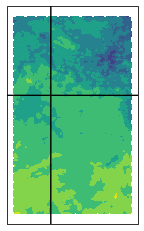

In [89]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

temp_in_region = data.where(check_boundaries, drop=True)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.contourf(temp_in_region.longitude, temp_in_region.latitude, temp_in_region.TMP)
ax.add_feature(cfeature.STATES)

plt.show()

Note that we never had to use the projection coordinates for this example.